# Shopify Challenge

At Shopify, we have precisely 100 sneaker shops, and each of these shops sells only one model of shoe. We want to analyze the average order value (AOV). When looking at order data over a 30-day window, we naively calculate an AOV of &#36;3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.


In [1]:
# import necessary packages

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# set the scene
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### The Dataset

The dataset is taken from [this link](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0) provided by Shopify challenge description.

The dataset consists of 5000 entries with no missing values. Therefore, there is no need to think of the ways of imputations. All entries represent values for a single month from March 1 to March 30, 2017. Since there is a datetime instance, we can convert it on the fly for easier manipulation.

In [2]:
# load dataset
shopify = pd.read_csv('data/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv',
                      parse_dates=['created_at'], index_col=0)

# set type to "category"
shopify['payment_method'] = shopify['payment_method'].astype('category')

# verify there are no missing values
shopify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   shop_id         5000 non-null   int64         
 1   user_id         5000 non-null   int64         
 2   order_amount    5000 non-null   int64         
 3   total_items     5000 non-null   int64         
 4   payment_method  5000 non-null   category      
 5   created_at      5000 non-null   datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(4)
memory usage: 239.4 KB


In [3]:
# check first instances
shopify.head(3)

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
1,53,746,224,2,cash,2017-03-13 12:36:56
2,92,925,90,1,cash,2017-03-03 17:38:52
3,44,861,144,1,cash,2017-03-14 04:23:56


In [5]:
# check the dates
dates = shopify['created_at']
print(f'Min date: {dates.min()}\nMax date: {dates.max()}\nDifference: {dates.max() - dates.min()}')

Min date: 2017-03-01 00:08:09
Max date: 2017-03-30 23:55:35
Difference: 29 days 23:47:26


Just reading the description of the assignment already states that the AOV number is ridiculously high. Indeed, sneakers are something that anyone could afford, but giving away over &#36;3000 on average is just wrong. We need to look into the descriptive statistics to get the first insights.

After a careful analysis, it became evident what was causing the problem. First of all, AOV is a naive way of calculating the mean of the column, there is nothing fancy going on there. However, we should always be cautious about the “mean” behavior. It gets dragged around fiercely in case of outliers. A quick overview and descriptive statistics can give the first steps into the investigation.

In [4]:
shopify.describe()

,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,50.078800,849.092400,3145.128000,8.78720
std,29.006118,87.798982,41282.539349,116.32032
min,1.000000,607.000000,90.000000,1.00000
25%,24.000000,775.000000,163.000000,1.00000
50%,50.000000,849.000000,284.000000,2.00000
75%,75.000000,925.000000,390.000000,3.00000
max,100.000000,999.000000,704000.000000,2000.00000


The above shows the descriptive statistics for the numeric values of the dataset. Here we can see a couple of interesting points about the order_amount and total_items columns:
1. The average (mean) value of the order_amount column is &#36;3,145.13 as given in the dataset description, so now we know where the number came from.

2. The standard deviation of the order_amount column is &#36;41,282.54 which indicates that the dataset has a high variation. Looking at the quantiles shows that the main spread is within &#36;90 to &#36;390 which is more believable than the price given above.

3. The same behavior is observed for the total_items column. The average (mean) value is almost 9. This means that people buy almost 9 pairs of shoes in one go which is clearly wrong. Moreover, we can see the maximum value of 2,000 items per order. This could be the wholesale buyers which should be treated differently in a separate dataset.

### Exploratory Data Analysis

The above code revealed high variance. We need to see which shops are dragging the whole dataset's metrics. For starters, we need to verify that there are indeed 100 stores. After the verification, we will use boxplot and kdeplots to get the distribution insights.

For fun, we will also check the price, total purchase, and frequency of buying. It will also be interesting to see the TOP places and check whether selling them for less drives the overall revenue.



In [6]:
# verify the number of stores
print('Number of unique stores:', shopify.shop_id.nunique())

Number of unique stores: 100


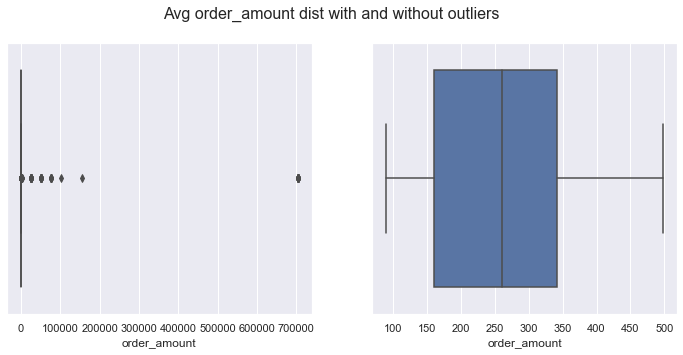

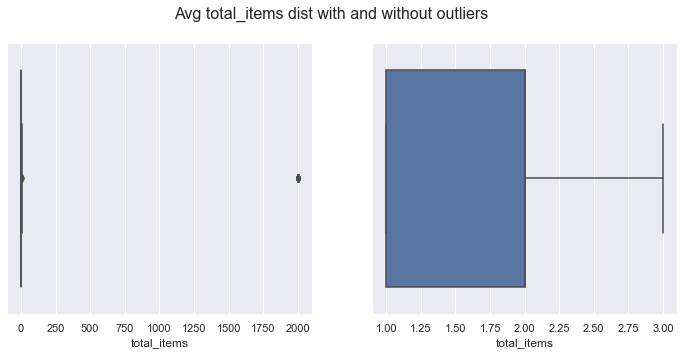

In [14]:
def side_by_side(df, col, thresh):
    outlier = df[df[col] > thresh]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Avg {col} dist with and without outliers', fontsize=16)
    sns.boxplot(data=df, x=col, ax=ax[0])
    sns.boxplot(data=df.drop(index=outlier.index, axis='rows'), x=col, ax=ax[1])
    plt.show()

# visualize distributions
side_by_side(shopify, 'order_amount', 500)
side_by_side(shopify, 'total_items',  3)

In [5]:
# 
normalized = shopify.shop_id.value_counts(normalize=True) * 100
print(f'Number of stores that make up more than 1% of revenue: {len(normalized[normalized > 1.])}')

# show all
normalized

Number of stores that make up more than 1% of revenue: 47


53    1.36
71    1.32
19    1.28
13    1.26
89    1.22
      ... 
74    0.76
56    0.74
67    0.74
38    0.70
85    0.70
Name: shop_id, Length: 100, dtype: float64

In [6]:
# get TOP best and worst performing stores
top10    = shopify[shopify['shop_id'].isin(normalized.head(10).index)]
bottom10 = shopify[shopify['shop_id'].isin(normalized.tail(10).index)]

In [7]:
print(f'AOV for TOP-10 places: ${format(top10["order_amount"].mean(), ".2f")}')
print(f'AOV for BOTTOM-10 places: ${format(bottom10["order_amount"].mean(), ".2f")}')

AOV for TOP-10 places: $291.11
AOV for BOTTOM-10 places: $291.99


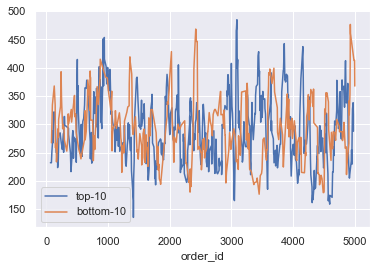

In [8]:
fig, ax = plt.subplots(1, 1)
top10.rolling(7).mean().plot(y='order_amount', ax=ax, label='top-10')
bottom10.rolling(7).mean().plot(y='order_amount', ax=ax, label='bottom-10')
plt.show()

<AxesSubplot:xlabel='order_id'>

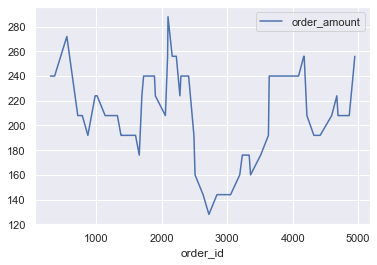

In [9]:
top10[top10['shop_id'] == 53].rolling(7).mean().plot(y='order_amount')

### Outliers

In [10]:
data = shopify.groupby('shop_id').agg({'order_amount': ['mean', 'min', 'max'], 'total_items': ['count', 'mean']})
data.columns = ['usd_mean', 'usd_min', 'usd_max', 'n_items', 'n_mean']
data.sort_values(['usd_mean', 'n_mean'], ascending=False)

,usd_mean,usd_min,usd_max,n_items,n_mean
shop_id,,,,,
42,235101.490196,352,704000,51,667.901961
78,49213.043478,25725,154350,46,1.913043
50,403.545455,193,965,44,2.090909
90,403.224490,178,890,49,2.265306
38,390.857143,190,760,35,2.057143
...,...,...,...,...,...
53,214.117647,112,560,68,1.911765
100,213.675000,111,444,40,1.925000
32,189.976190,101,404,42,1.880952


In [47]:
indices     = shopify['shop_id'].isin([42, 78])
outliers    = shopify[indices]
no_outliers = shopify[~indices]

print(f'AOV of the dataset with outliers: ${format(shopify.order_amount.median(), ".2f")}')
print(f'AOV of the dataset without outliers: ${format(no_outliers.order_amount.median(), ".2f")}')
print(f'AOV of outlier shops (#42 & #78): ${format(outliers.order_amount.median(), ".2f")}')

AOV of the dataset with outliers: $284.00
AOV of the dataset without outliers: $284.00
AOV of outlier shops (#42 & #78): $25725.00


In [46]:
no_outliers.describe()

,shop_id,user_id,order_amount,total_items
count,4903.000000,4903.000000,4903.000000,4903.000000
mean,49.900877,849.858862,300.155823,1.995717
std,29.154367,86.887947,155.941112,0.982602
min,1.000000,700.000000,90.000000,1.000000
25%,24.000000,776.000000,163.000000,1.000000
50%,50.000000,850.000000,284.000000,2.000000
75%,74.000000,925.000000,386.500000,3.000000
max,100.000000,999.000000,1086.000000,8.000000


In [49]:
no_outliers[no_outliers['total_items'] <= 3]['order_amount'].describe()

count    4528.000000
mean      272.708481
std       123.299903
min        90.000000
25%       160.000000
50%       266.000000
75%       352.000000
max       603.000000
Name: order_amount, dtype: float64

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
outliers.rolling(7).mean().plot(y='order_amount', ax=ax[0], label='outliers')
shopify[~shopify['shop_id'].isin([42, 78])].rolling(7).mean().plot(y='order_amount', ax=ax[0], label='no outliers')

sns.histplot(data=outliers.groupby('shop_id')['total_items'].count(), ax=ax[1])
sns.histplot(data=no_outliers.groupby('shop_id')['total_items'].count(), ax=ax[1])
plt.show()

In [17]:
outliers

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
41,42,793,352,1,credit_card,2017-03-24 14:15:41
61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
161,78,990,25725,1,credit_card,2017-03-12 05:56:57
309,42,770,352,1,credit_card,2017-03-11 18:14:39
...,...,...,...,...,...,...
4746,42,872,352,1,debit,2017-03-24 00:57:24
4768,42,720,704,2,credit_card,2017-03-14 10:26:08
4869,42,607,704000,2000,credit_card,2017-03-22 04:00:00


In [39]:
temp = outliers.groupby('shop_id')[['order_amount', 'total_items']].value_counts().reset_index()
temp.columns = ['shop_id', 'order_amount', 'items_per_order', 'count']
temp

,shop_id,order_amount,items_per_order,count
0,42,704000,2000,17
1,42,352,1,15
2,42,704,2,13
3,42,1056,3,3
4,42,1408,4,2
5,42,1760,5,1
6,78,25725,1,19
7,78,51450,2,16
8,78,77175,3,9
9,78,102900,4,1


In [42]:
shopify[shopify['shop_id'] == 39][['order_amount', 'total_items']].value_counts().reset_index()

,order_amount,total_items,0
0,268,2,16
1,134,1,15
2,402,3,6
3,536,4,3
4,670,5,1


In [43]:
outliers.describe()

,shop_id,user_id,order_amount,total_items
count,97.000000,97.000000,97.000000,97.000000
mean,59.072165,810.350515,146948.206186,352.072165
std,18.069454,119.869811,259684.063661,763.604054
min,42.000000,607.000000,352.000000,1.000000
25%,42.000000,740.000000,704.000000,1.000000
50%,42.000000,819.000000,25725.000000,2.000000
75%,78.000000,910.000000,77175.000000,3.000000
max,78.000000,997.000000,704000.000000,2000.000000


In [25]:
shopify.shop_id.value_counts().reset_index()

,index,shop_id
0,53,68
1,71,66
2,19,64
3,13,63
4,89,61
...,...,...
95,74,38
96,56,37
97,67,37
98,38,35


In [73]:
shopify[shopify['shop_id'] == 53].agg({'order_amount': ['min', 'mean', 'max', 'count']})

,order_amount
min,112.000000
mean,214.117647
max,560.000000
count,68.000000


In [12]:
shopify.created_at.min(), shopify.created_at.max()

(Timestamp('2017-03-01 00:08:09'), Timestamp('2017-03-30 23:55:35'))

In [29]:
data = shopify.groupby('shop_id').agg({'order_amount': ['mean', 'min', 'max'], 'total_items': ['count', 'mean']})
data.columns = ['usd_mean', 'usd_min', 'usd_max', 'n_items', 'n_mean']
data.sort_values(['usd_mean', 'n_mean'], ascending=False)

,usd_mean,usd_min,usd_max,n_items,n_mean
shop_id,,,,,
42,235101.490196,352,704000,51,667.901961
78,49213.043478,25725,154350,46,1.913043
50,403.545455,193,965,44,2.090909
90,403.224490,178,890,49,2.265306
38,390.857143,190,760,35,2.057143
...,...,...,...,...,...
53,214.117647,112,560,68,1.911765
100,213.675000,111,444,40,1.925000
32,189.976190,101,404,42,1.880952


In [33]:
shopify[(shopify['shop_id'] == 42) & (shopify['order_amount'] > 2000)]

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00
1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00
1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00


In [37]:
shopify[(shopify['shop_id'] == 78)]

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
161,78,990,25725,1,credit_card,2017-03-12 05:56:57
491,78,936,51450,2,debit,2017-03-26 17:08:19
494,78,983,51450,2,cash,2017-03-16 21:39:35
512,78,967,51450,2,cash,2017-03-09 07:23:14
618,78,760,51450,2,cash,2017-03-18 11:18:42
692,78,878,154350,6,debit,2017-03-27 22:51:43
1057,78,800,25725,1,debit,2017-03-15 10:16:45
1194,78,944,25725,1,debit,2017-03-16 16:38:26
1205,78,970,25725,1,credit_card,2017-03-17 22:32:21


## Exploratory Data Analysis

The description states that all the 100 shops sell only one model of shoes. We will first need to verify there are indeed 100 stores. Then, it is worth checking the price, total purchase, and frequency of buying. It will also be interesting to see the TOP places and check whether selling them for less drives the overall revenue.

Moreover, having Average Order Value (AOV) of &#36;3145.13 does not make any sense. The


We want to analyze the average order value (AOV). When looking at order data over a 30-day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

## Visualizations

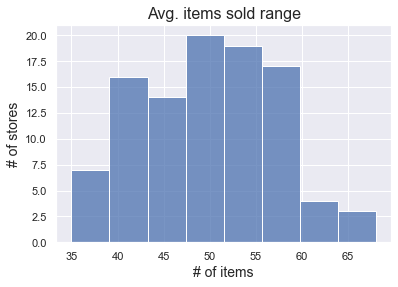

In [47]:
sns.histplot(data=data, x='n_items')
plt.title('Avg. items sold range', fontsize=16)
plt.xlabel('# of items', fontsize=14)
plt.ylabel('# of stores', fontsize=14)
plt.show()

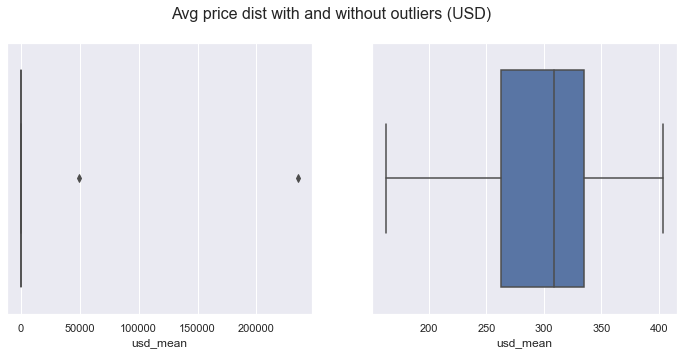

In [63]:
# sns.histplot(data=data, x='usd_mean', bins=30)
outliers = data[data['usd_mean'] > data['usd_mean'].std() * 1.5]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Avg price dist with and without outliers (USD)', fontsize=16)
sns.boxplot(data=data, x='usd_mean', ax=ax[0])
sns.boxplot(data=data.drop(index=outliers.index, axis='rows'), x='usd_mean', ax=ax[1])
plt.show()

In [60]:
data[data['usd_mean'] > data['usd_mean'].std() * 1.5]

,usd_mean,usd_min,usd_max,n_items,n_mean
shop_id,,,,,
42,235101.490196,352,704000,51,667.901961
78,49213.043478,25725,154350,46,1.913043


In [65]:
data.describe()

,usd_mean,usd_min,usd_max,n_items,n_mean
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3136.834088,407.990000,9269.290000,50.000000,8.652863
std,23935.881130,2557.462906,71837.231886,7.287737,66.590946
min,162.857143,90.000000,399.000000,35.000000,1.731707
25%,263.675962,132.750000,588.500000,44.750000,1.912724
50%,308.889758,153.000000,709.000000,50.000000,1.981125
75%,336.628352,168.250000,806.250000,55.000000,2.076250
max,235101.490196,25725.000000,704000.000000,68.000000,667.901961


In [66]:
shopify.describe()

,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,50.078800,849.092400,3145.128000,8.78720
std,29.006118,87.798982,41282.539349,116.32032
min,1.000000,607.000000,90.000000,1.00000
25%,24.000000,775.000000,163.000000,1.00000
50%,50.000000,849.000000,284.000000,2.00000
75%,75.000000,925.000000,390.000000,3.00000
max,100.000000,999.000000,704000.000000,2000.00000


## AOV

At Shopify, we have precisely 100 sneaker shops, and each of these shops sells only one model of shoe. We want to analyze the average order value (AOV). When looking at order data over a 30-day window, we naively calculate an AOV of 3145.13 USD. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.


$$AOV=\frac{revenue}{# orders}$$

In [69]:
# with the outliers
# revenue    = shopify['order_amount'].sum()
# total_sold = shopify['total_items'].sum()
#
# aov        = revenue / total_sold
# aov

shopify['order_amount'].mean()

3145.128

In [71]:
no_outliers = shopify[~shopify['shop_id'].isin([42, 78])]
no_outliers['order_amount'].mean()

300.1558229655313